In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [195]:
#Define the number of elements in each set I, J, K
i_num = 30
k_num = 2
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [196]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 25000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 25000), 0)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 25000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 25000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 25000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 25000), 0)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,12096.0,2831.0
j1,j1,19589.0,9136.0
j2,j2,17233.0,15056.0
j3,j3,15898.0,14492.0
j4,j4,9836.0,2669.0
...,...,...,...
i25,i25,1027.0,7773.0
i26,i26,21561.0,1406.0
i27,i27,22718.0,1958.0


In [197]:
# ### PASSAU  ###

# #Define sets of I, J, K, where J contains I and K for Passau

# #Define the number of elements in each set I, J, K

# degree_to_m = 111111

# #Define empty data frames
# I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

# column_types = {
#     'Name': 'str',  # Example: 'int', 'float', 'str', 'datetime64[ns]', etc.
#     'Latitude': 'float',
#     'Longitude': 'float',
#     'Address': 'str'
#     # Add more columns and their data types as needed
# }

# doctors = pd.read_csv('Doctors coordinates.txt', sep = ';', index_col = False, dtype=column_types)

# doctors

# for i in range(len(doctors['Latitude'])):
#     I_coordinates.loc[i, 'Point number'] = 'i'+ str(i)
#     I_coordinates.loc[i, 'Latitude'] = doctors.loc[i, 'Latitude']
#     I_coordinates.loc[i, 'Longitude'] = doctors.loc[i, 'Longitude']

# I_coordinates.index = I_coordinates['Point number']

# I = I_coordinates * degree_to_m
# I['Point number'] = I_coordinates['Point number']


# labs = pd.read_csv('Labs coordinates.txt', sep = ';', index_col = False, dtype=column_types) 
# labs

# for k in range(len(labs['Latitude'])):
#     K_coordinates.loc[k, 'Point number'] = 'k'+ str(k)
#     K_coordinates.loc[k, 'Latitude'] = labs.loc[k, 'Latitude']
#     K_coordinates.loc[k, 'Longitude'] = labs.loc[k, 'Longitude']

# K_coordinates.index = K_coordinates['Point number']

# K = K_coordinates * degree_to_m
# K['Point number'] = K_coordinates['Point number']


# #Define range of coordinates

# combined_coordinates = pd.concat([I_coordinates, K_coordinates])

# min_latitude = combined_coordinates['Latitude'].min()
# max_latitude = combined_coordinates['Latitude'].max()
# min_longitude = combined_coordinates['Longitude'].min()
# max_longitude = combined_coordinates['Longitude'].max()

# grid_spacing = 0.0018

# # Create grid points
# grid_points = []
# for lat in np.arange(min_latitude, max_latitude + grid_spacing, grid_spacing):
#     for lon in np.arange(min_longitude, max_longitude + grid_spacing, grid_spacing):
#         grid_points.append((round(lat, 6), round(lon, 6)))

# J_coordinates = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude'])
# J_coordinates['Point number'] = ['j' + str(i) for i in range(len(J_coordinates))]

# J_coordinates.index = J_coordinates['Point number'] 
# J_coordinates = pd.concat([J_coordinates, K_coordinates, I_coordinates], axis = 0) #Include K to J

# river = ['j972', 'j973', 'j918', 'j919', 'j920', 'j866', 'j867', 'j813', 'j814',
# 'j815', 'j760', 'j761', 'j762', 'j707', 'j708', 'j709', 'j710', 'j654',
# 'j655', 'j656', 'j657', 'j658', 'j606', 'j610', 'j611', 'j612', 'j613', 'j614',
# 'j615', 'j616', 'j620', 'j621', 'j622', 'j623', 'j624', 'j625', 'j682', 'j683',
# 'j684','j685','j686', 'j635', 'j636', 'j637', 'j638', 'j585', 'j586', 'j587', 
# 'j588', 'j589', 'j590', 'j591', 'j592','j593', 'j531', 'j530', 'j529', 'j528',
# 'j527', 'j22', 'j23', 'j77', 'j132', 'j133', 'j134', 'j189', 'j190', 'j244',
# 'j245', 'j300', 'j301', 'j356', 'j411', 'j412', 'j467', 'j523', 'j524', 'j525', 'j526',

# 'j246', 'j247', 'j191', 'j192', 'j193', 'j194', 'j135', 'j136', 'j137', 'j138', 'j139',
# 'j140', 'j141', 'j78', 'j79', 'j80', 'j81', 'j82', 'j83', 'j84', 'j85', 'j86', 'j87', 'j88',
# 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36',
#  'j261', 'j262', 'j263', 'j264', 'j266', 'j267', 'j268', 'j269', 'j206', 'j207', 'j208',
# 'j209', 'j210', 'j211', 'j212', 'j213', 'j214', 'j215', 'j153', 'j154', 'j155', 'j156',
# 'j157', 'j158', 'j159', 'j160', 'j161', 'j98', 'j99', 'j100', 'j101', 'j102', 'j103', 
# 'j104', 'j105', 'j106', 'j107', 'j43', 'j44', 'j45', 'j46', 'j47', 'j48', 'j49', 'j50', 
# 'j51', 'j52', 'j53'
#  ]

# J_coordinates = J_coordinates.drop(index = river) #excluding locations on the river

# J = J_coordinates * degree_to_m
# J['Point number'] = J_coordinates['Point number']
# J


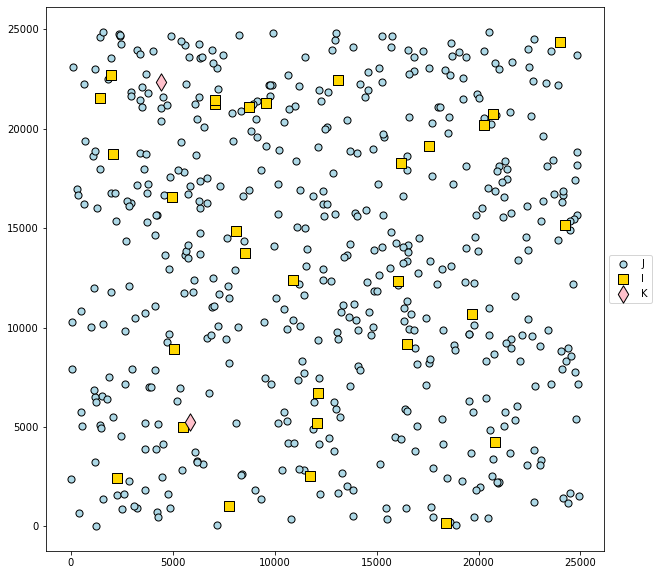

In [198]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [199]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib



# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Making Passau polygon

# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)

# passau_poly = shapely.wkt.loads(polygon_str)
# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# folium.GeoJson(passau_gdf).add_to(passau_map)


# # Assuming I_coordinates is your DataFrame with doctor coordinates
# geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']], 
#                   icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
# geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_labs.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']], 
#                   icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
# geo_bases = gpd.GeoDataFrame(J_coordinates, geometry=gpd.points_from_xy(J_coordinates["Latitude"], J_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_bases.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.CircleMarker([row['Latitude'], row['Longitude']],  
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


# #Custom legend

# legend_html = '''
#      <div style="position: fixed; 
#                  bottom: 100px; right: 100px; width: 300px; height: 150px; 
#                  border:2px solid grey; z-index:9999; font-size:16px;
#                  background-color:white; opacity: 0.9;
#                  ">
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:orange"></i> Doctors &nbsp; <br>
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:red"></i> Laboratories &nbsp; <br>
#      &nbsp; <svg height="40" width="40">
#           <circle cx="20" cy="20" r="18" fill="none" stroke="#3388FF" stroke-width="2" />
#         </svg> Bases &nbsp; 
#       </div>
#      '''



# # Add the legend to the map
# passau_map.get_root().html.add_child(folium.Element(legend_html))

# passau_map

In [200]:
#Define constants

B = 15000 #battery load: meters of travel
S = 5100 #meters of service time

p = 0.98

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45



softlimit = 200
hardlimit = 10000


In [201]:
up_bound = 10
mu = {i : int(round(random.uniform(1, up_bound), 0)) for i in I.index}
# mu = {'i0': 3,
#  'i1': 9, 'i2': 4, 'i3': 6, 'i4': 5, 'i5': 10, 'i6': 5, 'i7': 9, 'i8': 2, 'i9': 8, 'i10': 7, 'i11': 9, 'i12': 5, 'i13': 5, 'i14': 6, 'i15': 5, 'i16': 6, 'i17': 3, 'i18': 2,
#  'i19': 3, 'i20': 10, 'i21': 6, 'i22': 3, 'i23': 3, 'i24': 5, 'i25': 4, 'i26': 7, 'i27': 8, 'i28': 6, 'i29': 3, 'i30': 6, 'i31': 9, 'i32': 4, 'i33': 8, 'i34': 6, 'i35': 3,
#  'i36': 1, 'i37': 2, 'i38': 2, 'i39': 6, 'i40': 9, 'i41': 8, 'i42': 3, 'i43': 3, 'i44': 9, 'i45': 3, 'i46': 9, 'i47': 2, 'i48': 8, 'i49': 8, 'i50': 10, 'i51': 10, 'i52': 9,
#  'i53': 10, 'i54': 8, 'i55': 5, 'i56': 8, 'i57': 8, 'i58': 1, 'i59': 5, 'i60': 6, 'i61': 2, 'i62': 8, 'i63': 2, 'i64': 3, 'i65': 4, 'i66': 10, 'i67': 7, 'i68': 3, 'i69': 5,
#  'i70': 5, 'i71': 2, 'i72': 8, 'i73': 2, 'i74': 2, 'i75': 9, 'i76': 9}

Deterministic model

In [202]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

# theta_det = {'i0': 2, 'i1': 14, 'i2': 4, 'i3': 7, 'i4': 4, 'i5': 9, 'i6': 8, 'i7': 13, 'i8': 2, 'i9': 6, 'i10': 10, 'i11': 14, 'i12': 9, 'i13': 3, 'i14': 5, 'i15': 8, 'i16': 6,
#  'i17': 1, 'i18': 1, 'i19': 2, 'i20': 6, 'i21': 5, 'i22': 3, 'i23': 3, 'i24': 4, 'i25': 8, 'i26': 12, 'i27': 8, 'i28': 5, 'i29': 3, 'i30': 4, 'i31': 6, 'i32': 3, 'i33': 9, 'i34': 7,
#  'i35': 3, 'i36': 0, 'i37': 2, 'i38': 0, 'i39': 9, 'i40': 11, 'i41': 8, 'i42': 6, 'i43': 7, 'i44': 4, 'i45': 1, 'i46': 5, 'i47': 4, 'i48': 5, 'i49': 8, 'i50': 3, 'i51': 6, 'i52': 10,
#  'i53': 14, 'i54': 5, 'i55': 12, 'i56': 7, 'i57': 10, 'i58': 1, 'i59': 9, 'i60': 2, 'i61': 1, 'i62': 10, 'i63': 3, 'i64': 3, 'i65': 3, 'i66': 7, 'i67': 10, 'i68': 3, 'i69': 5,
#  'i70': 4, 'i71': 1, 'i72': 7, 'i73': 1, 'i74': 1, 'i75': 15, 'i76': 7}

{'i0': 10,
 'i1': 11,
 'i2': 5,
 'i3': 9,
 'i4': 9,
 'i5': 3,
 'i6': 3,
 'i7': 1,
 'i8': 7,
 'i9': 6,
 'i10': 2,
 'i11': 3,
 'i12': 13,
 'i13': 8,
 'i14': 4,
 'i15': 8,
 'i16': 6,
 'i17': 4,
 'i18': 3,
 'i19': 7,
 'i20': 7,
 'i21': 2,
 'i22': 13,
 'i23': 5,
 'i24': 9,
 'i25': 8,
 'i26': 6,
 'i27': 2,
 'i28': 14,
 'i29': 4}

In [203]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 7471.528692309225,
 ('k0', 'j1'): 14692.872591838533,
 ('k0', 'j2'): 15092.233267479005,
 ('k0', 'j3'): 13694.920518206742,
 ('k0', 'j4'): 5573.812070746555,
 ('k0', 'j5'): 4404.697946511202,
 ('k0', 'j6'): 21613.093485200123,
 ('k0', 'j7'): 18114.38558163097,
 ('k0', 'j8'): 6486.31675143914,
 ('k0', 'j9'): 10779.4705806918,
 ('k0', 'j10'): 5071.728009268636,
 ('k0', 'j11'): 22460.007858413584,
 ('k0', 'j12'): 21559.114476248786,
 ('k0', 'j13'): 18947.739917995495,
 ('k0', 'j14'): 18365.203647114835,
 ('k0', 'j15'): 4935.236569811015,
 ('k0', 'j16'): 11928.073859596947,
 ('k0', 'j17'): 15685.13602108697,
 ('k0', 'j18'): 8471.567741569443,
 ('k0', 'j19'): 14324.553605610194,
 ('k0', 'j20'): 7318.816639320868,
 ('k0', 'j21'): 3129.1329469998554,
 ('k0', 'j22'): 11876.330157081353,
 ('k0', 'j23'): 19963.11511262709,
 ('k0', 'j24'): 24458.416956131892,
 ('k0', 'j25'): 3804.96649131106,
 ('k0', 'j26'): 11130.627700179357,
 ('k0', 'j27'): 6953.6972899314505,
 ('k0', 'j28'): 16

In [204]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j8'),
 ('k0', 'j10'),
 ('k0', 'j15'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j25'),
 ('k0', 'j27'),
 ('k0', 'j32'),
 ('k0', 'j38'),
 ('k0', 'j45'),
 ('k0', 'j51'),
 ('k0', 'j66'),
 ('k0', 'j68'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j76'),
 ('k0', 'j80'),
 ('k0', 'j92'),
 ('k0', 'j95'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j115'),
 ('k0', 'j120'),
 ('k0', 'j133'),
 ('k0', 'j136'),
 ('k0', 'j146'),
 ('k0', 'j147'),
 ('k0', 'j168'),
 ('k0', 'j173'),
 ('k0', 'j175'),
 ('k0', 'j182'),
 ('k0', 'j184'),
 ('k0', 'j187'),
 ('k0', 'j188'),
 ('k0', 'j197'),
 ('k0', 'j199'),
 ('k0', 'j200'),
 ('k0', 'j202'),
 ('k0', 'j203'),
 ('k0', 'j206'),
 ('k0', 'j208'),
 ('k0', 'j214'),
 ('k0', 'j220'),
 ('k0', 'j224'),
 ('k0', 'j240'),
 ('k0', 'j245'),
 ('k0', 'j246'),
 ('k0', 'j248'),
 ('k0', 'j252'),
 ('k0', 'j257'),
 ('k0', 'j258'),
 ('k0', 'j262'),
 ('k0', 'j272'),
 ('k0', 'j274'),
 ('k0', '

In [205]:
#Define set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= 0.5*B:
        P.append((i, k))
        
P

[('i0', 'k1'),
 ('i2', 'k0'),
 ('i4', 'k1'),
 ('i6', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0'),
 ('i20', 'k1'),
 ('i21', 'k1'),
 ('i22', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k1'),
 ('i27', 'k1'),
 ('i28', 'k1'),
 ('i29', 'k1')]

In [206]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas


[('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j8'),
 ('k0', 'j10'),
 ('k0', 'j15'),
 ('k0', 'j21'),
 ('k0', 'j25'),
 ('k0', 'j27'),
 ('k0', 'j32'),
 ('k0', 'j38'),
 ('k0', 'j45'),
 ('k0', 'j51'),
 ('k0', 'j66'),
 ('k0', 'j68'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j76'),
 ('k0', 'j80'),
 ('k0', 'j92'),
 ('k0', 'j95'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j115'),
 ('k0', 'j120'),
 ('k0', 'j136'),
 ('k0', 'j146'),
 ('k0', 'j147'),
 ('k0', 'j168'),
 ('k0', 'j173'),
 ('k0', 'j175'),
 ('k0', 'j187'),
 ('k0', 'j188'),
 ('k0', 'j197'),
 ('k0', 'j199'),
 ('k0', 'j200'),
 ('k0', 'j202'),
 ('k0', 'j203'),
 ('k0', 'j206'),
 ('k0', 'j208'),
 ('k0', 'j214'),
 ('k0', 'j220'),
 ('k0', 'j224'),
 ('k0', 'j240'),
 ('k0', 'j246'),
 ('k0', 'j248'),
 ('k0', 'j252'),
 ('k0', 'j257'),
 ('k0', 'j258'),
 ('k0', 'j262'),
 ('k0', 'j272'),
 ('k0', 'j274'),
 ('k0', 'j279'),
 ('k0', 'j287'),
 ('k0', 'j303'),
 ('k0', 'j304'),
 ('k0', 'j318'),
 ('k0', 'j327'),
 ('k0'

In [207]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i

{'i0': [('k1', 'j1'),
  ('k1', 'j7'),
  ('k1', 'j16'),
  ('k1', 'j17'),
  ('k1', 'j19'),
  ('k1', 'j28'),
  ('k1', 'j33'),
  ('k1', 'j36'),
  ('k1', 'j55'),
  ('k1', 'j75'),
  ('k1', 'j83'),
  ('k1', 'j84'),
  ('k1', 'j86'),
  ('k1', 'j89'),
  ('k1', 'j99'),
  ('k1', 'j104'),
  ('k1', 'j138'),
  ('k1', 'j139'),
  ('k1', 'j142'),
  ('k1', 'j160'),
  ('k1', 'j195'),
  ('k1', 'j213'),
  ('k1', 'j221'),
  ('k1', 'j226'),
  ('k1', 'j228'),
  ('k1', 'j232'),
  ('k1', 'j234'),
  ('k1', 'j235'),
  ('k1', 'j242'),
  ('k1', 'j243'),
  ('k1', 'j270'),
  ('k1', 'j271'),
  ('k1', 'j276'),
  ('k1', 'j280'),
  ('k1', 'j292'),
  ('k1', 'j293'),
  ('k1', 'j294'),
  ('k1', 'j298'),
  ('k1', 'j311'),
  ('k1', 'j314'),
  ('k1', 'j317'),
  ('k1', 'j330'),
  ('k1', 'j338'),
  ('k1', 'j356'),
  ('k1', 'j389'),
  ('k1', 'j428'),
  ('k1', 'j432'),
  ('k1', 'j433'),
  ('k1', 'j445'),
  ('k1', 'j450'),
  ('k1', 'j458'),
  ('k1', 'j469'),
  ('k1', 'k1'),
  ('k1', 'i0'),
  ('k1', 'i4'),
  ('k1', 'i20'),
  ('k1', '

In [208]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j1',
 'j4',
 'j5',
 'j7',
 'j8',
 'j9',
 'j10',
 'j14',
 'j15',
 'j16',
 'j17',
 'j19',
 'j21',
 'j25',
 'j26',
 'j27',
 'j28',
 'j32',
 'j33',
 'j36',
 'j38',
 'j39',
 'j45',
 'j48',
 'j51',
 'j52',
 'j55',
 'j64',
 'j65',
 'j66',
 'j68',
 'j70',
 'j71',
 'j72',
 'j73',
 'j75',
 'j76',
 'j79',
 'j80',
 'j82',
 'j83',
 'j84',
 'j86',
 'j87',
 'j89',
 'j92',
 'j95',
 'j98',
 'j99',
 'j101',
 'j102',
 'j104',
 'j112',
 'j115',
 'j117',
 'j120',
 'j124',
 'j131',
 'j135',
 'j136',
 'j138',
 'j139',
 'j142',
 'j145',
 'j146',
 'j147',
 'j150',
 'j152',
 'j160',
 'j168',
 'j173',
 'j175',
 'j185',
 'j187',
 'j188',
 'j189',
 'j191',
 'j195',
 'j196',
 'j197',
 'j199',
 'j200',
 'j202',
 'j203',
 'j206',
 'j208',
 'j213',
 'j214',
 'j220',
 'j221',
 'j224',
 'j226',
 'j228',
 'j232',
 'j234',
 'j235',
 'j236',
 'j240',
 'j242',
 'j243',
 'j246',
 'j248',
 'j252',
 'j257',
 'j258',
 'j259',
 'j262',
 'j270',
 'j271',
 'j272',
 'j274',
 'j276',
 'j279',
 'j280',
 'j282',
 'j283',
 'j287',
 '

In [209]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [210]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j21'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j25'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j27'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j32'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j38'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j45'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j51'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j66'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j68'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j70'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j71'): <gurobi.Constr *Awaiting Model Updat

In [211]:
model_det.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
model_det.setParam('TimeLimit', hardlimit)
model_det.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6835 rows, 7432 columns and 8214 nonzeros
Model fingerprint: 0x6d6016e1
Variable types: 0 continuous, 7432 integer (532 binary)
Coefficient statistics:
  Matrix range     [2e-03, 4e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+01]
Found heuristic solution: objective 4258225.1033
Presolve removed 6714 rows and 6870 columns
Presolve time: 0.02s
Presolved: 121 rows, 562 columns, 1011 nonzeros
Found heuristic solution: objective 3067984.6039
Variable types: 0 continuous, 562 integer (113 binary)
Found heuristic solution: objective 2661984.5162

Root relaxation: objective 1.916127e+06, 324 iterations, 0.00 seconds (0.00 work units)

    Nodes    

In [212]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 5
0
1.9269e+06 
x_ikj[i0,k1,i21] 10
x_ikj[i2,k0,i2] 5
x_ikj[i4,k1,i21] 9
x_ikj[i6,k0,k0] 3
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,k0] 3
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,i21] 7
x_ikj[i21,k1,i21] 2
x_ikj[i22,k0,i22] 13
x_ikj[i25,k0,k0] 8
x_ikj[i26,k1,i29] 6
x_ikj[i27,k1,i29] 2
x_ikj[i28,k1,i29] 14
x_ikj[i29,k1,i29] 4
y_j[k0] 1
y_j[i2] 1
y_j[i21] 1
y_j[i22] 1
y_j[i29] 1


1
2.00382e+06 
x_ikj[i0,k1,i21] 10
x_ikj[i2,k0,i2] 5
x_ikj[i4,k1,i21] 9
x_ikj[i6,k0,k0] 3
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,k0] 3
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,i21] 7
x_ikj[i21,k1,i21] 2
x_ikj[i22,k0,i22] 13
x_ikj[i25,k0,k0] 8
x_ikj[i26,k1,i29] 6
x_ikj[i27,k1,i29] 2
x_ikj[i28,k1,i29] 14
x_ikj[i29,k1,i29] 4
y_j[k0] 1
y_j[i2] 1
y_j[i21] 1
y_j[i22] 1
y_j[i29] 1


2
2.66198e+06 
x_ikj[i0,k1,i21] 10
x_ikj[i2,k0,i2] 5
x_ikj[i4,k1,i21] 9
x_ikj[i6,k0,k0] 3
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,k0] 3
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,i21] 7
x_ikj[i21,k1,i21] 2
x_ikj[i22,k0,i22] 13
x_ikj[i25,k0,k0] 8
x_ikj[i26,k1,i29

In [213]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    total_drones = sum(results['Number of drones'])
    total_locations = results['j'].nunique()
    return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                10
 1   i17                 4
 2   i18                 3
 3   i19                 7
 4    i2                 5
 5   i20                 7
 6   i21                 2
 7   i22                13
 8   i25                 8
 9   i26                 6
 10  i27                 2
 11  i28                14
 12  i29                 4
 13   i4                 9
 14   i6                 3,
      j  Number of drones
 0   i2                 5
 1  i21                28
 2  i22                17
 3  i29                26
 4   k0                21,
     k  Number of drones
 0  k0                43
 1  k1                54,
 'Total number of drones: 97',
 'Total number of locations: 5')

In [214]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (20, 20))
                
        fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Longitude'][i] - 40, I['Latitude'][i] - 15))
                
        fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Longitude'][k] - 40, K['Latitude'][k] - 15))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        (J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.plot((I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        #(I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                         #color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                #(K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                                fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                (J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

#SolutionGraph(I, K, J, model_det)

In [215]:
# def SolutionMap(I_coordinates, K_coordinates, J_coordinates, model):
        
#         with open('Polygon Passau.txt', 'r') as file:
#         # Read the contents of the file into a string
#                 polygon_str = file.read()

#         # Making Passau polygon
#         passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
#         passau_poly = shapely.wkt.loads(polygon_str)
#         passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
#         folium.GeoJson(passau_gdf).add_to(passau_map)

#         # Assuming I_coordinates is your DataFrame with doctor coordinates
#         geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326") 
        
#         indices_xi = []
#         indices_y = pd.DataFrame(columns = ['Location name', 'Latitude', 'Longitude'])
#         indices_x = pd.DataFrame(columns = ['I', 'J', 'Number of drones'])
        
        
#         i = 0
#         for v in model.getVars():
#                 if v.x > 0:
#                         if v.varName.startswith('x_ikj'):
#                                 indices_xi = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
#                                 indices_x.loc[i, 'I'] = str(indices_xi[0])
#                                 indices_x.loc[i, 'J'] = str(indices_xi[2])
#                                 indices_x.loc[i, 'Number of drones'] = int(v.x)
#                                 i += 1
                                
#                         else:
#                                 y_name = v.varName[4:-1]
#                                 indices_y.loc[str(y_name), 'Latitude'] = J_coordinates.loc[str(y_name), 'Latitude']
#                                 indices_y.loc[str(y_name), 'Longitude'] = J_coordinates.loc[str(y_name), 'Longitude']
#                                 indices_y.loc[str(y_name), 'Location name'] = str(y_name)
#                                 # 
#                                 # fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
#                                 #         edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                        
#         geo_solution_y = gpd.GeoDataFrame(indices_y, geometry=gpd.points_from_xy(indices_y["Latitude"], indices_y["Longitude"]), crs="epsg:4326")
        
        
        
#         for idx, row in geo_doctors.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']], 
#                         icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
                
        
        
#         geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

#         for idx, row in geo_labs.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']], 
#                                 icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
#                                 popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
       
#         for idx, row in geo_solution_y.iterrows():
#                 coordinates_label = f"Loc: {row['Location name']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']], 
#                         icon=folium.Icon(icon='circle', prefix='fa', color='green', size = 0.1), 
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
        
#         for idx, row in indices_x.iterrows():
#                 point_i = I_coordinates.loc[row['I'], ['Latitude', 'Longitude']]
#                 point_j = J_coordinates.loc[row['J'], ['Latitude', 'Longitude']]
#                 folium.PolyLine(locations=[(point_i['Latitude'], point_i['Longitude']), 
#                                         (point_j['Latitude'], point_j['Longitude'])], color='blue').add_to(passau_map)
                
#                 label = str(row['Number of drones'])
#                 div_icon_style = "background-color: white; border-radius: 50%; padding: 5px;"

#                 circle_size = 20
#                 folium.Marker([(point_i['Latitude'] + point_j['Latitude']) / 2, (point_i['Longitude'] + point_j['Longitude']) / 2], icon=folium.DivIcon(
#                 html=f"<div style='{div_icon_style}; width: {circle_size}px; height: {circle_size}px;'><div style='font-size: 10pt; color: blue;'>{label}</div></div>")).add_to(passau_map)
        
       
#         return passau_map


# SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_det)

Probabilistic model

In [216]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 7

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in I_feasG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))
g_i

{'i0': 56,
 'i1': 70,
 'i2': 35,
 'i3': 56,
 'i4': 56,
 'i5': 49,
 'i6': 28,
 'i7': 28,
 'i8': 56,
 'i9': 28,
 'i10': 21,
 'i11': 35,
 'i12': 42,
 'i13': 28,
 'i14': 35,
 'i15': 63,
 'i16': 56,
 'i17': 28,
 'i18': 21,
 'i19': 21,
 'i20': 42,
 'i21': 21,
 'i22': 42,
 'i23': 35,
 'i24': 49,
 'i25': 63,
 'i26': 56,
 'i27': 21,
 'i28': 63,
 'i29': 14}

In [217]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [218]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [219]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j21'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j25'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j27'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j32'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j38'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j45'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j51'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j66'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j68'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j70'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j71'): <gurobi.Constr *Awaiting Model Updat

In [220]:
model_prob.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

In [221]:
model_prob.setParam('TimeLimit', hardlimit)
model_prob.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



Optimize a model with 7388 rows, 8650 columns and 723910 nonzeros
Model fingerprint: 0x80f799c8
Variable types: 0 continuous, 8650 integer (1750 binary)
Coefficient statistics:
  Matrix range     [1e-13, 4e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 2e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 5244028.1700
Presolve removed 7153 rows and 7732 columns
Presolve time: 0.41s
Presolved: 235 rows, 918 columns, 1629 nonzeros
Variable types: 0 continuous, 918 integer (220 binary)
Found heuristic solution: objective 5244028.0622

Root relaxation: objective 2.654683e+06, 729 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2654682.88    0   13 5244028.06 2654682.88  49.4%     -    

In [222]:
ListSolution(model_prob)

Number of solutions found: 10
0
2.96187e+06 
x_ikj[i0,k1,j292] 14
x_ikj[i2,k0,i2] 10
x_ikj[i4,k1,j292] 14
x_ikj[i6,k0,k0] 9
x_ikj[i17,k0,i17] 9
x_ikj[i18,k0,k0] 7
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,j292] 12
x_ikj[i21,k1,j292] 7
x_ikj[i22,k0,i17] 12
x_ikj[i25,k0,k0] 16
x_ikj[i26,k1,j292] 14
x_ikj[i27,k1,j292] 7
x_ikj[i28,k1,j292] 16
x_ikj[i29,k1,j292] 5
y_j[j292] 1
y_j[k0] 1
y_j[i2] 1
y_j[i17] 1


1
2.98963e+06 
x_ikj[i0,k1,j292] 14
x_ikj[i2,k0,i2] 10
x_ikj[i4,k1,j292] 14
x_ikj[i6,k0,k0] 9
x_ikj[i17,k0,i17] 9
x_ikj[i18,k0,k0] 7
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,j292] 12
x_ikj[i21,k1,j292] 7
x_ikj[i22,k0,i17] 12
x_ikj[i25,k0,k0] 16
x_ikj[i26,k1,j292] 14
x_ikj[i27,k1,j292] 7
x_ikj[i28,k1,j292] 16
x_ikj[i29,k1,j292] 5
y_j[j292] 1
y_j[k0] 1
y_j[i2] 1
y_j[i17] 1


2
2.98963e+06 
x_ikj[i0,k1,j292] 14
x_ikj[i2,k0,i2] 10
x_ikj[i4,k1,j292] 14
x_ikj[i6,k0,k0] 9
x_ikj[i17,k0,i17] 9
x_ikj[i18,k0,k0] 7
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,j292] 12
x_ikj[i21,k1,j292] 7
x_ikj[i22,k0,i17] 12
x_ikj[i25,k0,k0] 16


In [223]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                14
 1   i17                 9
 2   i18                 7
 3   i19                 7
 4    i2                10
 5   i20                12
 6   i21                 7
 7   i22                12
 8   i25                16
 9   i26                14
 10  i27                 7
 11  i28                16
 12  i29                 5
 13   i4                14
 14   i6                 9,
       j  Number of drones
 0   i17                21
 1    i2                10
 2  j292                89
 3    k0                39,
     k  Number of drones
 0  k0                70
 1  k1                89,
 'Total number of drones: 159',
 'Total number of locations: 4')

In [224]:
#SolutionGraph(I, K, J, model_prob)

In [225]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob)

Probabilistic model with relaxed constraints

In [226]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j32'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j40'),
 ('k0', 'j43'),
 ('k0', 'j45'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j76'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j85'),
 ('k0', 'j90'),
 ('k0', 'j91'),
 ('k0', 'j92'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j107'),
 ('k0', 'j113'),
 ('k0', 'j114'),
 ('k0', 'j

In [227]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))
        
P

[('i0', 'k1'),
 ('i1', 'k0'),
 ('i1', 'k1'),
 ('i2', 'k0'),
 ('i3', 'k1'),
 ('i4', 'k1'),
 ('i5', 'k1'),
 ('i6', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i11', 'k1'),
 ('i15', 'k0'),
 ('i15', 'k1'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i18', 'k1'),
 ('i19', 'k0'),
 ('i20', 'k1'),
 ('i21', 'k1'),
 ('i22', 'k0'),
 ('i23', 'k1'),
 ('i24', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k1'),
 ('i27', 'k1'),
 ('i28', 'k0'),
 ('i28', 'k1'),
 ('i29', 'k0'),
 ('i29', 'k1')]

In [228]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j32'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j40'),
 ('k0', 'j43'),
 ('k0', 'j45'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j76'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j85'),
 ('k0', 'j90'),
 ('k0', 'j91'),
 ('k0', 'j92'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j113'),
 ('k0', 'j115'),
 ('k0', 'j117'),
 ('k0', 'j118'),
 ('k0', 'j120'),
 ('k0', 'j126'),
 ('k0',

In [229]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())

In [230]:
#Redefine sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j7',
 'j8',
 'j9',
 'j10',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j32',
 'j33',
 'j34',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j43',
 'j45',
 'j48',
 'j49',
 'j51',
 'j52',
 'j55',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j104',
 'j112',
 'j113',
 'j115',
 'j117',
 'j118',
 'j120',
 'j124',
 'j125',
 'j126',
 'j127',
 'j128',
 'j131',
 'j132',
 'j133',
 'j135',
 'j136',
 'j138',
 'j139',
 'j140',
 'j141',
 'j142',
 'j144',
 'j145',
 'j146',
 'j147',
 'j148',
 'j150',
 'j152',
 'j153',
 'j154',
 'j157',
 'j160',
 'j161',
 'j163',
 'j164',
 'j165',
 'j166',


In [231]:
#Redifine IG, I_feasG, h_ig

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in I_feasG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))

In [232]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [233]:

model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')
model_prob_rel.addConstrs((y_j[k] == 1 for k in K.index), name = 'c7')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{'k0': <gurobi.Constr *Awaiting Model Update*>,
 'k1': <gurobi.Constr *Awaiting Model Update*>}

In [234]:
model_prob_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_prob_rel.setParam('TimeLimit', hardlimit)
model_prob_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27640 rows, 18790 columns and 1415307 nonzeros
Model fingerprint: 0x9b9d2bef
Variable types: 0 continuous, 18790 integer (1750 binary)
Coefficient statistics:
  Matrix range     [1e-13, 4e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 9633946.2691
Presolve removed 27221 rows and 17135 columns
Presolve time: 0.96s
Presolved: 419 rows, 1655 columns, 2941 nonzeros
Found heuristic solution: objective 9227943.7360
Variable types: 0 continuous, 1655 integer (392 binary)
Found heuristic solution: objecti

In [235]:
ListSolution(model_prob_rel)

Number of solutions found: 10
0
5.55254e+06 
x_ikj[i0,k1,i0] 14
x_ikj[i1,k1,i28] 17
x_ikj[i2,k0,i17] 10
x_ikj[i3,k1,i5] 14
x_ikj[i4,k1,i0] 14
x_ikj[i5,k1,i5] 13
x_ikj[i6,k0,k0] 9
x_ikj[i8,k0,i8] 14
x_ikj[i9,k0,i9] 9
x_ikj[i10,k0,i10] 7
x_ikj[i11,k1,i28] 10
x_ikj[i15,k0,i15] 16
x_ikj[i16,k0,i16] 14
x_ikj[i17,k0,i17] 9
x_ikj[i18,k0,k0] 7
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,k1] 12
x_ikj[i21,k1,k1] 7
x_ikj[i22,k0,i17] 12
x_ikj[i23,k1,i0] 10
x_ikj[i24,k0,i16] 13
x_ikj[i25,k0,k0] 16
x_ikj[i26,k1,k1] 14
x_ikj[i27,k1,k1] 7
x_ikj[i28,k1,i28] 16
x_ikj[i29,k1,k1] 5
y_j[k0] 1
y_j[k1] 1
y_j[i0] 1
y_j[i5] 1
y_j[i8] 1
y_j[i9] 1
y_j[i10] 1
y_j[i15] 1
y_j[i16] 1
y_j[i17] 1
y_j[i28] 1


1
5.67862e+06 
x_ikj[i0,k1,i0] 14
x_ikj[i1,k1,i28] 17
x_ikj[i2,k0,i17] 10
x_ikj[i3,k1,i5] 14
x_ikj[i4,k1,i0] 14
x_ikj[i5,k1,i5] 13
x_ikj[i6,k0,k0] 9
x_ikj[i8,k0,i8] 14
x_ikj[i9,k0,i9] 9
x_ikj[i10,k0,i10] 7
x_ikj[i11,k1,i28] 10
x_ikj[i15,k0,i15] 16
x_ikj[i16,k0,i16] 14
x_ikj[i17,k0,i17] 9
x_ikj[i18,k0,k0] 7
x_ikj[i19,k0,k0] 7

In [236]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                14
 1    i1                17
 2   i10                 7
 3   i11                10
 4   i15                16
 5   i16                14
 6   i17                 9
 7   i18                 7
 8   i19                 7
 9    i2                10
 10  i20                12
 11  i21                 7
 12  i22                12
 13  i23                10
 14  i24                13
 15  i25                16
 16  i26                14
 17  i27                 7
 18  i28                16
 19  i29                 5
 20   i3                14
 21   i4                14
 22   i5                13
 23   i6                 9
 24   i8                14
 25   i9                 9,
       j  Number of drones
 0    i0                38
 1   i10                 7
 2   i15                16
 3   i16                27
 4   i17                31
 5   i28                43
 6    i5                27
 7    i8                14
 8    i9                 9


In [237]:
#SolutionGraph(I, K, J, model_prob_rel)

In [238]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob_rel)

Deterministic model with relaxed constraints

In [239]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [240]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')

model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')
model_det_rel.addConstrs((y_j[k] == 1 for k in K.index), name = 'c7')

{'k0': <gurobi.Constr *Awaiting Model Update*>,
 'k1': <gurobi.Constr *Awaiting Model Update*>}

In [241]:
model_det_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_det_rel.setParam('TimeLimit', hardlimit)
model_det_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 26580 rows, 17572 columns and 29526 nonzeros
Model fingerprint: 0xe5c70ff5
Variable types: 0 continuous, 17572 integer (532 binary)
Coefficient statistics:
  Matrix range     [6e-01, 4e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 7566934.6773
Presolve removed 26268 rows and 16608 columns
Presolve time: 0.01s
Presolved: 312 rows, 964 columns, 1628 nonzeros
Found heuristic solution: objective 5333932.2854
Variable types: 0 continuous, 964 integer (299 binary)
Found heuristic solution: objective 5333932.1626

Root relaxation: objective 3.353612e+06, 617 iterations, 0.00 seconds (0.00 work units)

    Nod

In [242]:
ListSolution(model_det_rel)

Number of solutions found: 8
0
3.40861e+06 
x_ikj[i0,k1,k1] 10
x_ikj[i1,k1,i11] 11
x_ikj[i2,k0,i22] 5
x_ikj[i3,k1,i5] 9
x_ikj[i4,k1,i4] 9
x_ikj[i5,k1,i5] 3
x_ikj[i6,k0,k0] 3
x_ikj[i8,k0,i8] 7
x_ikj[i9,k0,i9] 6
x_ikj[i10,k0,i10] 2
x_ikj[i11,k1,i11] 3
x_ikj[i15,k0,i11] 8
x_ikj[i16,k0,i16] 6
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,k0] 3
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,k1] 7
x_ikj[i21,k1,k1] 2
x_ikj[i22,k0,i22] 13
x_ikj[i23,k1,i4] 5
x_ikj[i24,k0,i16] 9
x_ikj[i25,k0,k0] 8
x_ikj[i26,k1,k1] 6
x_ikj[i27,k1,k1] 2
x_ikj[i28,k1,i11] 14
x_ikj[i29,k1,k1] 4
y_j[k0] 1
y_j[k1] 1
y_j[i4] 1
y_j[i5] 1
y_j[i8] 1
y_j[i9] 1
y_j[i10] 1
y_j[i11] 1
y_j[i16] 1
y_j[i22] 1


1
3.40861e+06 
x_ikj[i0,k1,k1] 10
x_ikj[i1,k1,i11] 11
x_ikj[i2,k0,i22] 5
x_ikj[i3,k1,i5] 9
x_ikj[i4,k1,i4] 9
x_ikj[i5,k1,i5] 3
x_ikj[i6,k0,k0] 3
x_ikj[i8,k0,i8] 7
x_ikj[i9,k0,i9] 6
x_ikj[i10,k0,i10] 2
x_ikj[i11,k1,i11] 3
x_ikj[i15,k0,i11] 8
x_ikj[i16,k0,i16] 6
x_ikj[i17,k0,i22] 4
x_ikj[i18,k0,k0] 3
x_ikj[i19,k0,k0] 7
x_ikj[i20,k1,k1] 7
x_ikj[i21,k1,

In [243]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                10
 1    i1                11
 2   i10                 2
 3   i11                 3
 4   i15                 8
 5   i16                 6
 6   i17                 4
 7   i18                 3
 8   i19                 7
 9    i2                 5
 10  i20                 7
 11  i21                 2
 12  i22                13
 13  i23                 5
 14  i24                 9
 15  i25                 8
 16  i26                 6
 17  i27                 2
 18  i28                14
 19  i29                 4
 20   i3                 9
 21   i4                 9
 22   i5                 3
 23   i6                 3
 24   i8                 7
 25   i9                 6,
      j  Number of drones
 0  i10                 2
 1  i11                36
 2  i16                15
 3  i22                22
 4   i4                14
 5   i5                12
 6   i8                 7
 7   i9                 6
 8   k0                21
 9   k1   

In [244]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_det_rel)

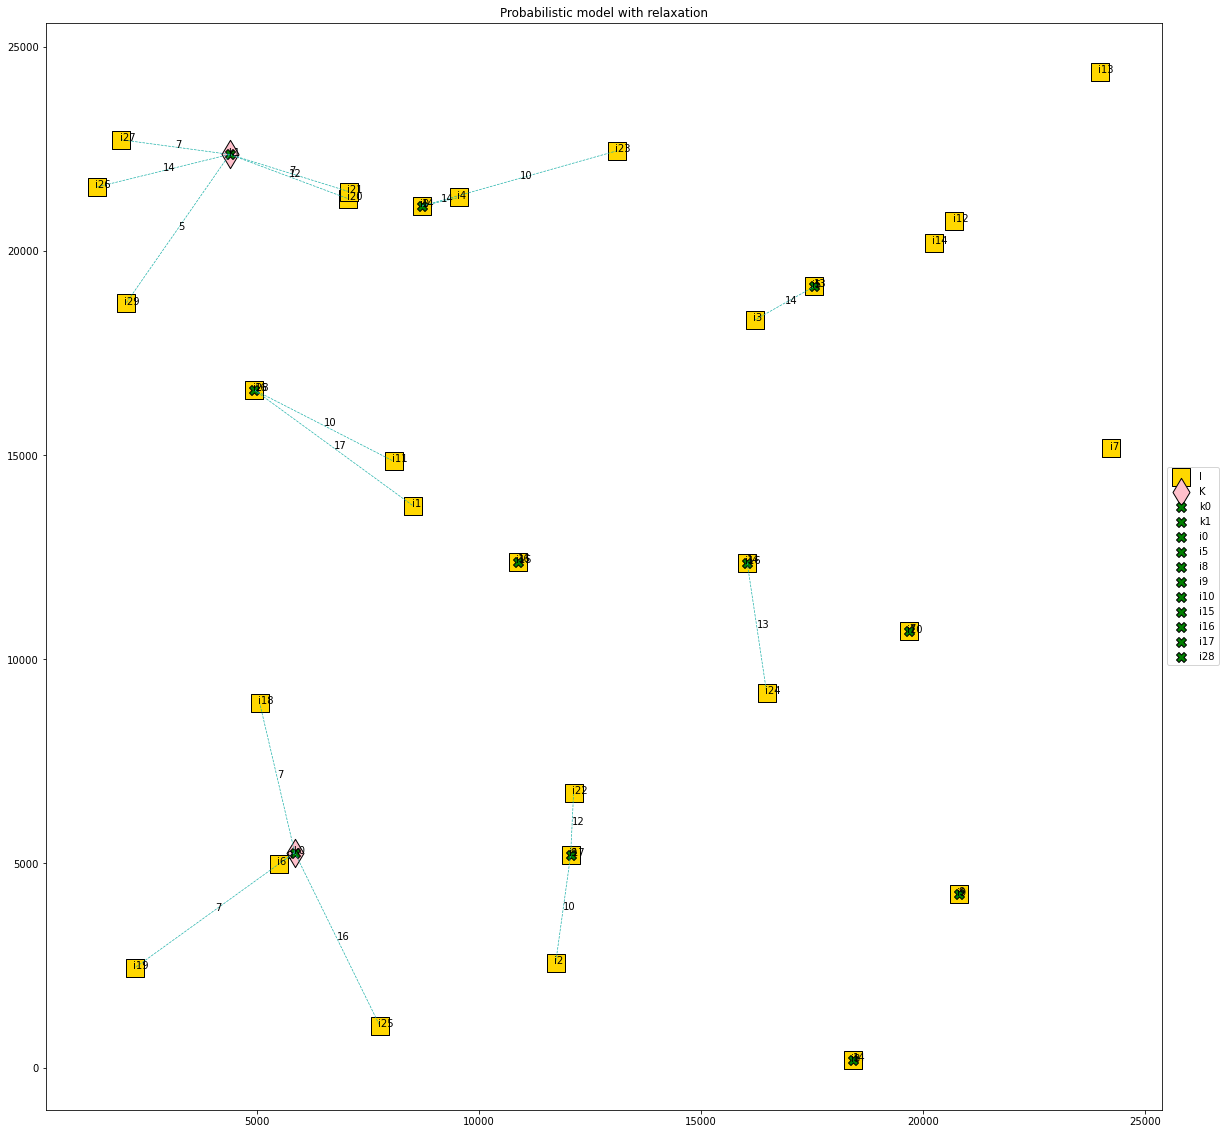

In [257]:
SolutionGraph(I, K, J, model_prob_rel)

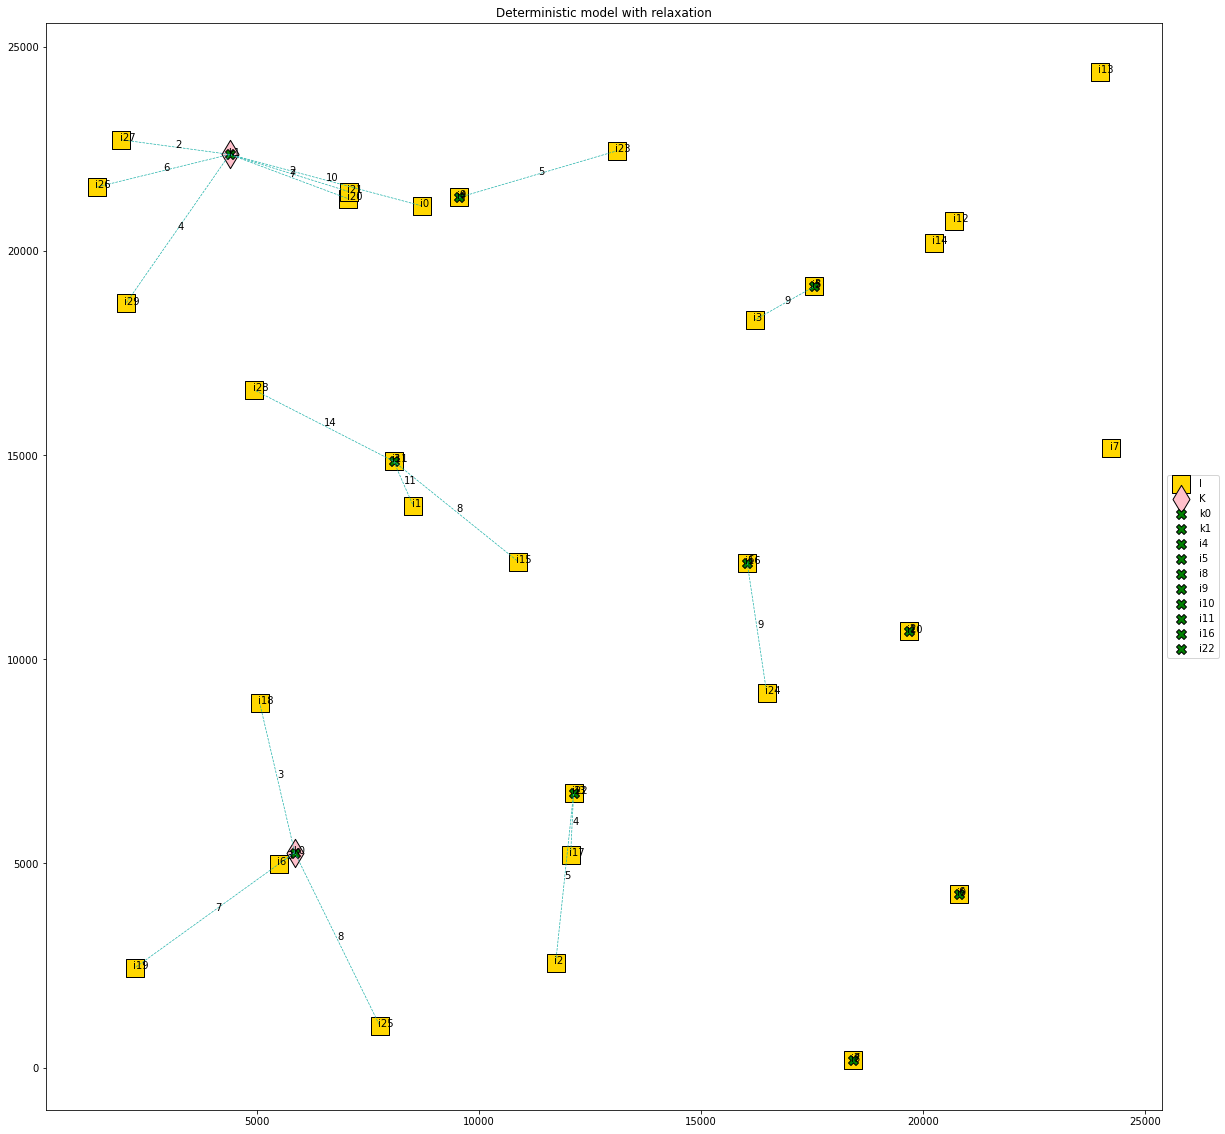

In [246]:
SolutionGraph(I, K, J, model_det_rel)

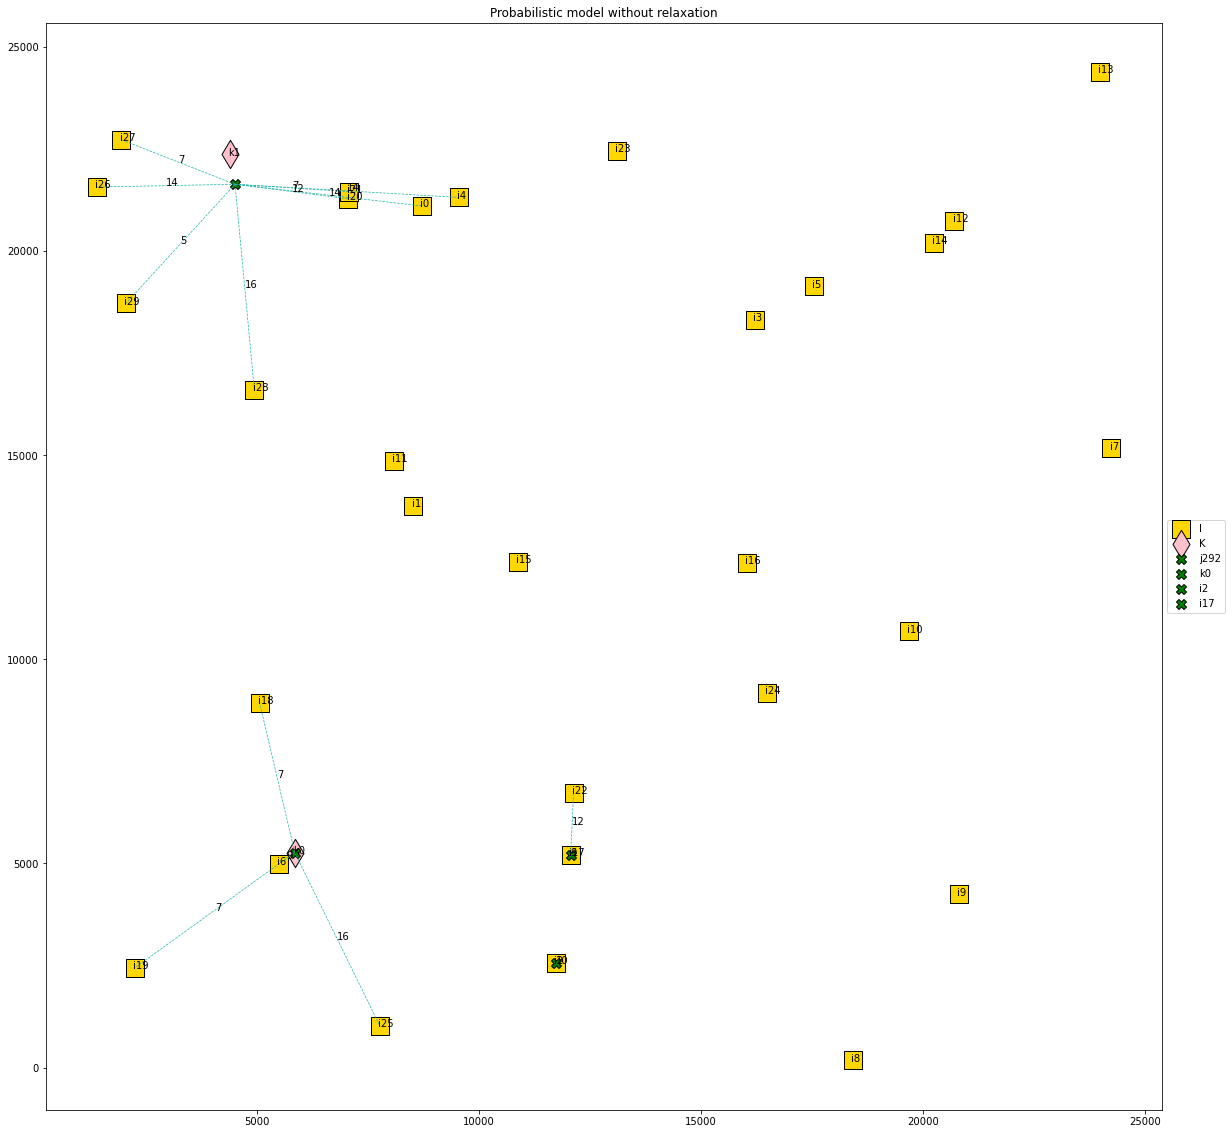

In [247]:
SolutionGraph(I, K, J, model_prob)

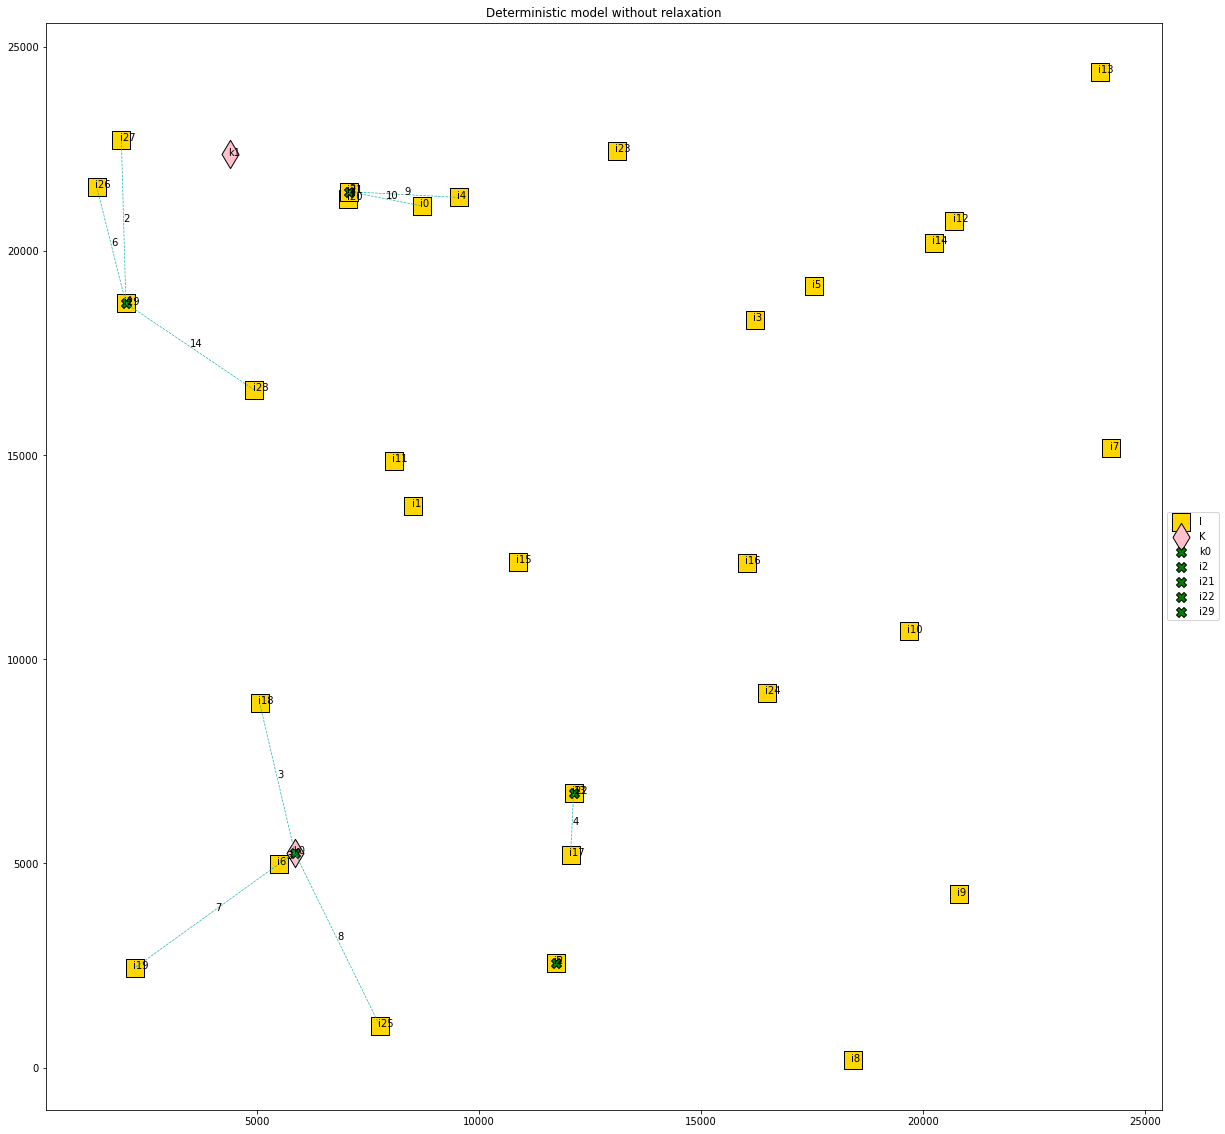

In [248]:
SolutionGraph(I, K, J, model_det)

GRAPHS

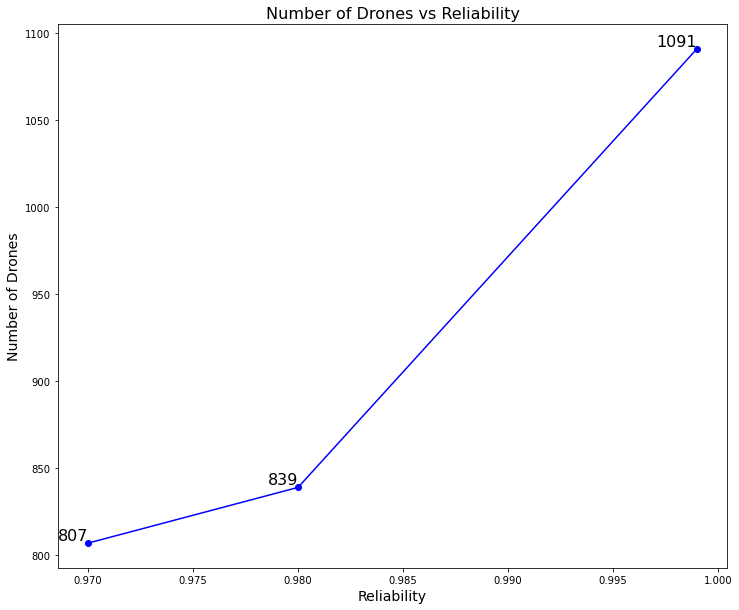

In [249]:
import matplotlib.pyplot as plt

p = [0.97, 0.98, 0.999]
number_of_drones = [807, 839, 1091]

# Plot
plt.figure(figsize=(12, 10))
plt.plot(p, number_of_drones, marker='o', color='blue', linestyle='-')
plt.title('Number of Drones vs Reliability', fontsize = 16)
plt.xlabel('Reliability', fontsize = 14)
plt.ylabel('Number of Drones', fontsize = 14)

# Add labels to points
for i in range(len(p)):
    plt.text(p[i], number_of_drones[i], f'{number_of_drones[i]}', ha='right', va='bottom', fontsize = 16)

plt.show()

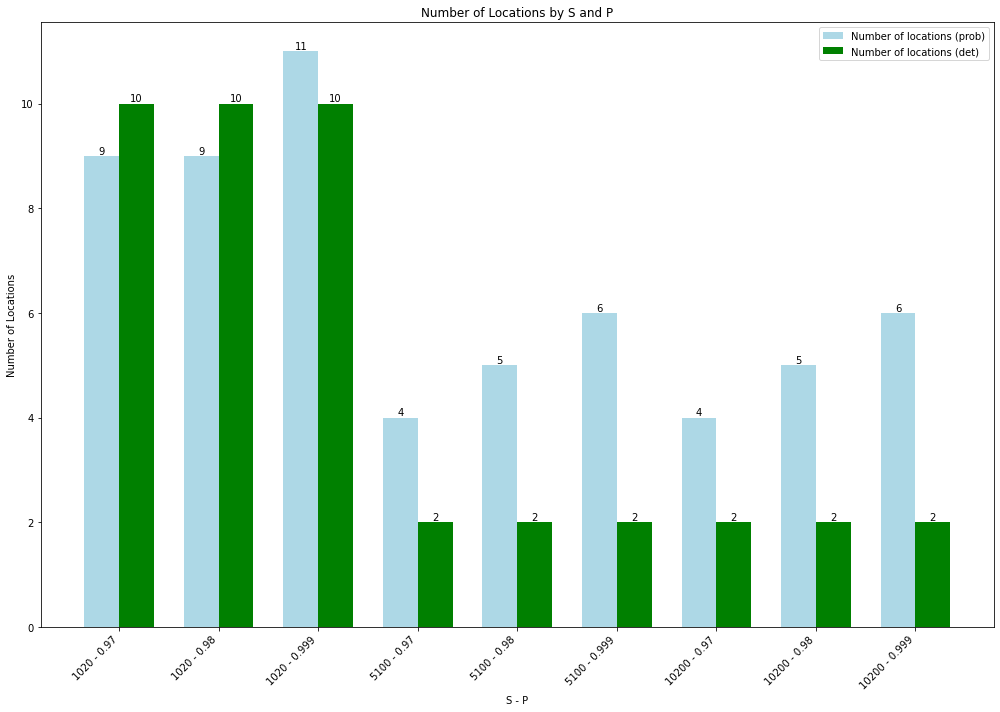

In [250]:
import numpy as np

# Data
S = [1020, 1020, 1020, 5100, 5100, 5100, 10200, 10200, 10200]
P = ['0.97', '0.98', '0.999'] * 3
locations_prob = [9, 9, 11, 4, 5, 6, 4, 5, 6]
locations_det = [10, 10, 10, 2, 2, 2, 2, 2, 2]

# Create indices for x-axis
x = np.arange(len(S))

# Width of each bar
bar_width = 0.35

# Plot
plt.figure(figsize=(14, 10))

# Plot Number of locations (prob)
bars_prob = plt.bar(x - bar_width/2, locations_prob, width=bar_width, color='lightblue', label='Number of locations (prob)')

# Plot Number of locations (det)
bars_det = plt.bar(x + bar_width/2, locations_det, width=bar_width, color='green', label='Number of locations (det)')

# Add labels and title
plt.xlabel('S - P')
plt.ylabel('Number of Locations')
plt.title('Number of Locations by S and P')
plt.xticks(x, [f'{S[i]} - {P[i]}' for i in range(len(S))], rotation=45, ha='right')
plt.legend()

# Add labels to the bars
for bars in [bars_prob, bars_det]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

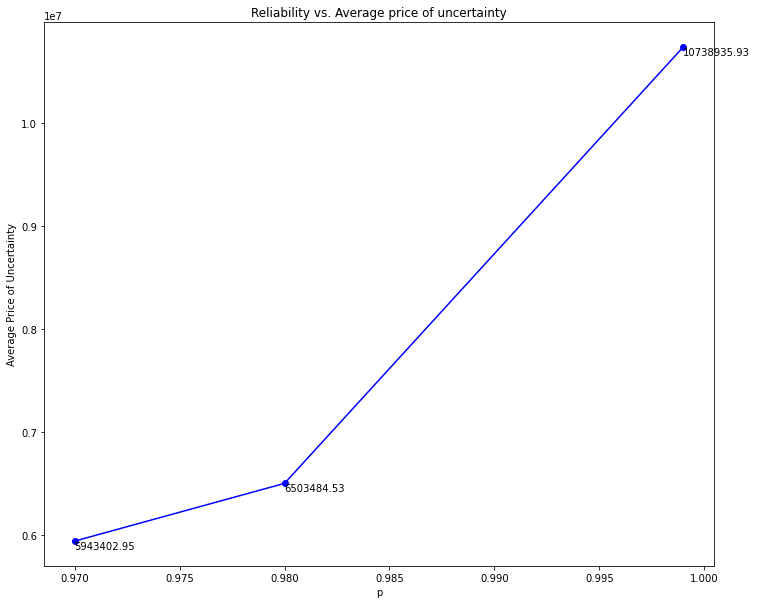

In [251]:
p = [0.97, 0.98, 0.999]
average_price = [5943402.954, 6503484.525, 10738935.93]

# Plot
plt.figure(figsize=(12, 10))
plt.plot(p, average_price, marker='o', color='blue', linestyle='-')
plt.title('Reliability vs. Average price of uncertainty')
plt.xlabel('p')
plt.ylabel('Average Price of Uncertainty')

# Add labels to points
for i in range(len(p)):
    plt.text(p[i], average_price[i], f'{average_price[i]:.2f}', ha='left', va='top')

plt.show()

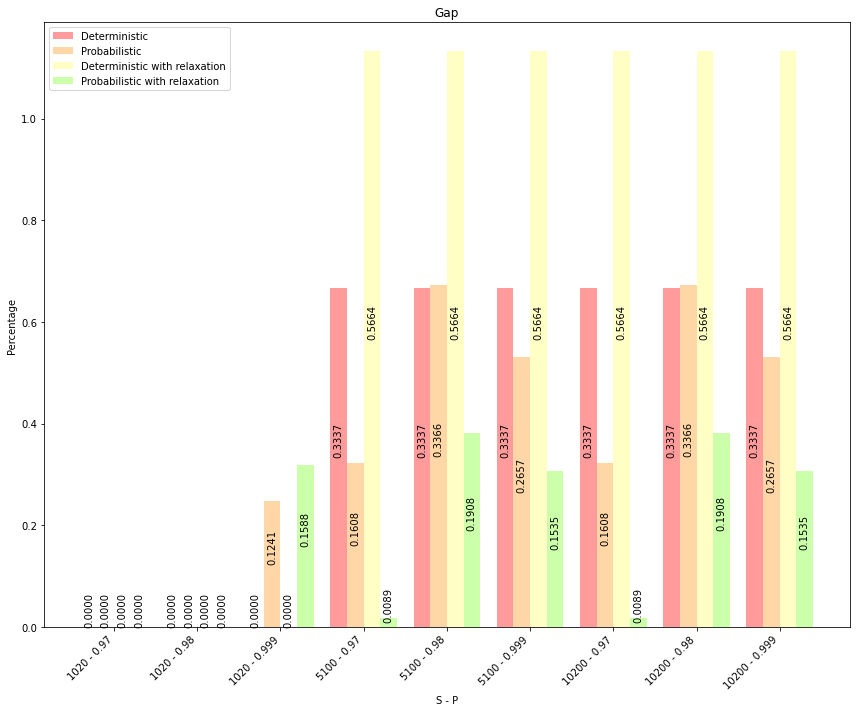

In [252]:
# Data
S = [1020, 1020, 1020, 5100, 5100, 5100, 10200, 10200, 10200]
P = ['0.97', '0.98', '0.999'] * 3
det = [0.0000, 0.0000, 0.0000, 0.6675, 0.6675, 0.6675, 0.6675, 0.6675, 0.6675]
prob = [0.0000, 0.0000, 0.2482, 0.3217, 0.6731, 0.5314, 0.3217, 0.6731, 0.5314]
det_relax = [0.0000, 0.0000, 0.0000, 1.1327, 1.1327, 1.1327, 1.1327, 1.1327, 1.1327]
prob_relax = [0.0000, 0.0000, 0.3177, 0.0177, 0.3817, 0.3070, 0.0177, 0.3817, 0.3070]

# Create indices for x-axis
x = np.arange(len(S))

# Width of each bar
bar_width = 0.2

# Plot
plt.figure(figsize=(12, 10))

# Plot Deterministic
bars_det = plt.bar(x - 1.5 * bar_width, det, width=bar_width, color='#FF9B9B', label='Deterministic')

# Plot Probabilistic
bars_prob = plt.bar(x - 0.5 * bar_width, prob, width=bar_width, color='#FFD6A5', label='Probabilistic')

# Plot Deterministic with relaxation
bars_det_relax = plt.bar(x + 0.5 * bar_width, det_relax, width=bar_width, color='#FFFEC4', label='Deterministic with relaxation')

# Plot Probabilistic with relaxation
bars_prob_relax = plt.bar(x + 1.5 * bar_width, prob_relax, width=bar_width, color='#CBFFA9', label='Probabilistic with relaxation')

# Add labels and title
plt.xlabel('S - P')
plt.ylabel('Percentage')
plt.title('Gap')
plt.xticks(x, [f'{S[i]} - {P[i]}' for i in range(len(S))], rotation=45, ha='right')
plt.legend()

# Add labels to the bars
for bars in [bars_det, bars_prob, bars_det_relax, bars_prob_relax]:
    for bar in bars:
        height = bar.get_height() / 2
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom', rotation = 90)

# Show plot
plt.tight_layout()
plt.show()

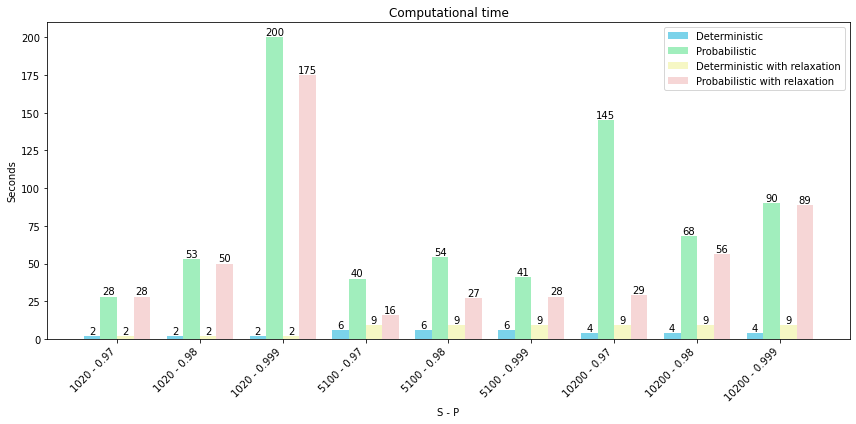

In [253]:
# Data
S = [1020, 1020, 1020, 5100, 5100, 5100, 10200, 10200, 10200]
P = ['0.97', '0.98', '0.999'] * 3
det = [2, 2, 2, 6, 6, 6, 4, 4, 4]
prob = [28, 53, 200, 40, 54, 41, 145, 68, 90]
det_relax = [2, 2, 2, 9, 9, 9, 9, 9, 9]
prob_relax = [28, 50, 175, 16, 27, 28, 29, 56, 89]

# Create indices for x-axis
x = np.arange(len(S))

# Width of each bar
bar_width = 0.2

# Plot
plt.figure(figsize=(12, 6))

# Plot Deterministic
bars_det = plt.bar(x - 1.5 * bar_width, det, width=bar_width, color='#7BD3EA', label='Deterministic')

# Plot Probabilistic
bars_prob = plt.bar(x - 0.5 * bar_width, prob, width=bar_width, color='#A1EEBD', label='Probabilistic')

# Plot Deterministic with relaxation
bars_det_relax = plt.bar(x + 0.5 * bar_width, det_relax, width=bar_width, color='#F6F7C4', label='Deterministic with relaxation')

# Plot Probabilistic with relaxation
bars_prob_relax = plt.bar(x + 1.5 * bar_width, prob_relax, width=bar_width, color='#F6D6D6', label='Probabilistic with relaxation')

# Add labels and title
plt.xlabel('S - P')
plt.ylabel('Seconds')
plt.title('Computational time')
plt.xticks(x, [f'{S[i]} - {P[i]}' for i in range(len(S))], rotation=45, ha='right')
plt.legend()

# Add labels to the bars
for bars in [bars_det, bars_prob, bars_det_relax, bars_prob_relax]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

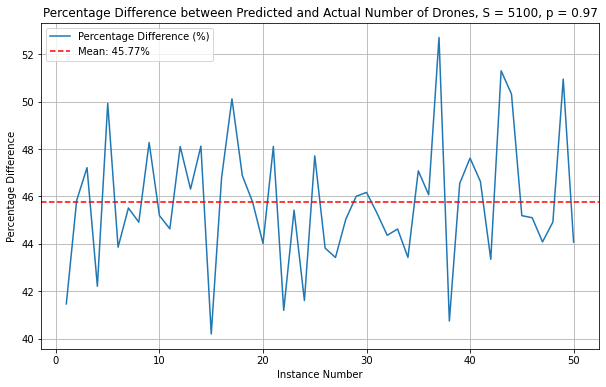

In [254]:
import matplotlib.pyplot as plt

# Provided data
model_numbers = [
    820, 816, 773, 770, 739, 700, 758, 757, 841, 759, 820, 767, 773, 694, 831, 
    735, 822, 787, 778, 727, 821, 857, 819, 834, 809, 801, 783, 817, 739, 797, 
    788, 780, 856, 753, 737, 790, 810, 837, 797, 777, 772, 789, 764, 763, 790, 
    776, 828, 797, 783, 810
]
actual_numbers = [
    480, 442, 408, 445, 370, 393, 413, 417, 435, 416, 454, 398, 415, 360, 497, 
    391, 410, 418, 422, 407, 426, 504, 447, 487, 423, 450, 443, 449, 399, 429, 
    431, 434, 474, 426, 390, 426, 383, 496, 426, 407, 412, 447, 372, 379, 433, 
    426, 463, 439, 384, 453
]

# Calculate percentage difference
percentage_difference = [((m - a) / m) * 100 for m, a in zip(model_numbers, actual_numbers)]

# Calculate mean percentage difference
mean_percentage_difference = sum(percentage_difference) / len(percentage_difference)

# Create the line graph for percentage difference
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(percentage_difference) + 1), percentage_difference, label='Percentage Difference (%)')
plt.axhline(y=mean_percentage_difference, color='r', linestyle='--', label=f'Mean: {mean_percentage_difference:.2f}%')
plt.xlabel('Instance Number')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference between Predicted and Actual Number of Drones, S = 5100, p = 0.97')
plt.legend()
plt.grid(True)
plt.show()

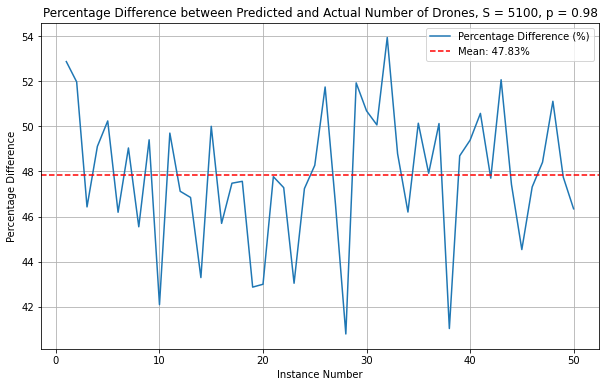

In [255]:
model_numbers = [
    872, 839, 812, 841, 842, 827, 781, 876, 836, 848, 829, 851, 777, 843, 846, 
    779, 813, 759, 807, 793, 829, 791, 755, 815, 810, 804, 825, 826, 832, 803, 
    821, 775, 781, 816, 732, 793, 818, 865, 879, 810, 787, 805, 824, 795, 824, 
    744, 816, 857, 779, 766
]

actual_numbers = [
    411, 403, 435, 428, 419, 445, 398, 477, 423, 491, 417, 450, 413, 478, 423, 
    423, 427, 398, 461, 452, 433, 417, 430, 430, 419, 388, 441, 489, 400, 396, 
    410, 357, 400, 439, 365, 413, 408, 510, 451, 410, 389, 421, 395, 418, 457, 
    392, 421, 419, 407, 411
]

# Calculate percentage difference
percentage_difference = [((m - a) / m) * 100 for m, a in zip(model_numbers, actual_numbers)]

# Calculate mean percentage difference
mean_percentage_difference = sum(percentage_difference) / len(percentage_difference)

# Create the line graph for percentage difference
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(percentage_difference) + 1), percentage_difference, label='Percentage Difference (%)')
plt.axhline(y=mean_percentage_difference, color='r', linestyle='--', label=f'Mean: {mean_percentage_difference:.2f}%')
plt.xlabel('Instance Number')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference between Predicted and Actual Number of Drones, S = 5100, p = 0.98')
plt.legend()
plt.grid(True)
plt.show()

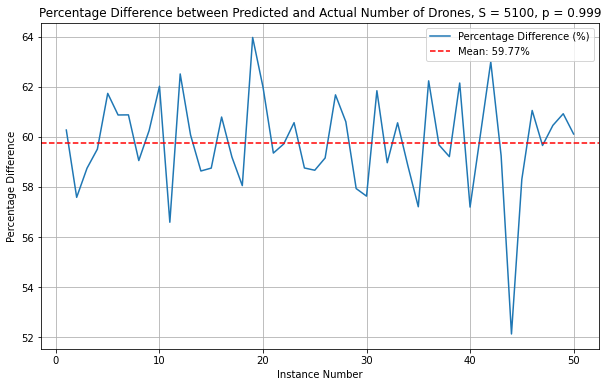

In [256]:
model_numbers = [
    1105, 1101, 1086, 1062, 1014, 1053, 1048, 1099, 1019, 1069, 1085, 1027, 1042, 
    1071, 1074, 1112, 1061, 1099, 1038, 1068, 1080, 1055, 1093, 1062, 1050, 1043, 
    1049, 1028, 1065, 1022, 1064, 987, 1070, 1013, 1096, 1091, 1116, 1064, 1070, 
    1084, 1090, 1062, 1146, 1128, 1060, 1063, 1103, 1004, 1062, 1048
]

actual_numbers = [
    439, 467, 448, 430, 388, 412, 410, 450, 405, 406, 471, 385, 416, 443, 443, 
    436, 433, 461, 374, 406, 439, 425, 431, 438, 434, 426, 402, 405, 448, 433, 
    406, 405, 422, 417, 469, 412, 450, 434, 405, 464, 435, 393, 467, 540, 442, 
    414, 445, 397, 415, 418
]

# Calculate percentage difference
percentage_difference = [((m - a) / m) * 100 for m, a in zip(model_numbers, actual_numbers)]

# Calculate mean percentage difference
mean_percentage_difference = sum(percentage_difference) / len(percentage_difference)

# Create the line graph for percentage difference
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(percentage_difference) + 1), percentage_difference, label='Percentage Difference (%)')
plt.axhline(y=mean_percentage_difference, color='r', linestyle='--', label=f'Mean: {mean_percentage_difference:.2f}%')
plt.xlabel('Instance Number')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference between Predicted and Actual Number of Drones, S = 5100, p = 0.999')
plt.legend()
plt.grid(True)
plt.show()